Preprocess data for curriculum learnining approach

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import prepocess_functs_CL as pp
from os import listdir
from os.path import isfile, join

In [2]:
nticks = 200
ADC_MIN = 5
path = '/home/vlian/Workspace/ar39-samples-full/'


In [3]:
# data loader
def get_data(wireplane, path, group, num_files):

    start = group*num_files
    end = start+num_files

    #noise_path = '../../../../train_dune_lartpc_v2/noise/'
    noise_path = '/home/vlian/Workspace/noise/'
    print('ar39: ', path)
    print('noise: ', noise_path)
    print('')
    print('----------loading----------')
    sig_name = wireplane+"-signal"
    cln_name = wireplane+"-clnsig"
    
    filenames1 = sorted([path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)])
    clean_filenames1 = sorted([path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)])
    filenames =  filenames1[start:end]
    #filenames =  filenames1
    clean_filenames = clean_filenames1[start:end]
    #clean_filenames = clean_filenames1
    noise_filenames = sorted([f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and wireplane in f)])

    combined_data = np.concatenate([np.load(fname, mmap_mode='r') for fname in filenames])
    combined_clean_data = np.concatenate([np.load(fname, mmap_mode='r') for fname in clean_filenames])
    combined_noise = np.concatenate([np.load(noise_path+fname, mmap_mode='r') for fname in noise_filenames])
    print('--------data loaded!-------')

    return combined_data, combined_clean_data, combined_noise
    #return combined_clean_data, combined_noise

In [4]:
grouping = {
    0: '(first 20 files)',
    1: '(secound 20 files)',
    2: '(third 20 files)',
    3: '(fourth 20 files)',
    4: '(fith 20 files)',
    5: '(sixth 20 files)',
    6: '(seventh 20 files)',
    7: '(eigth 20 files)',
    8: '(ninth 20 files)',
    9: '(last 20 files)'
}

Load data, filter of signal waveforms with ADC <= 3

In [5]:
def get_waves(wireplane, grp, num_files, ADC_MIN):
    # load raw data
    combined_data, combined_clean_data, combined_noise = get_data(wireplane, path, grp, num_files)

    # extract waveforms
    signal_waveforms = pp.get_std_waveforms(combined_data, nticks)
    clean_signal_waveforms = pp.get_std_waveforms(combined_clean_data, nticks)  # for autoencoder
    print('')
    signal_waveforms, clean_signal_waveforms = pp.filter_signal_ADC_min(signal_waveforms,
                                                clean_signal_waveforms, ADC_MIN)
    grouped_waves= pp.adc_grouping(signal_waveforms, clean_signal_waveforms)

    return grouped_waves

In [6]:
def get_samples(wireplane):
    adc_5_7_x = []
    adc_5_7_y = []

    adc_8_10_x = []
    adc_8_10_y = []

    adc_11_13_x = []
    adc_11_13_y = []

    adc_14_16_x = []
    adc_14_16_y = []

    adc_17_19_x = []
    adc_17_19_y = []

    adc_20_22_x = []
    adc_20_22_y = []

    adc_gt_22_x = []
    adc_gt_22_y = []

    grouped_waves = [
                    [adc_5_7_x, adc_5_7_y],
                    [adc_8_10_x, adc_8_10_y],
                    [adc_11_13_x, adc_11_13_y],
                    [adc_14_16_x, adc_14_16_y],
                    [adc_17_19_x, adc_17_19_y],
                    [adc_20_22_x, adc_20_22_y],
                    [adc_gt_22_x, adc_gt_22_y]
    ]

    for file_group in range(10):
        gr0 = get_waves(wireplane=wireplane, grp=file_group, num_files=20, ADC_MIN=ADC_MIN)
        num_samples = 200000

        for i, wave_set in enumerate(gr0[0]):
            if i == 0:
                continue
            grp = i
            x_idx = 0
            y_idx = 1
            num_entries_grp = len(grouped_waves[grp-1][x_idx])
            num_entries_ws = len(wave_set[x_idx])
            if num_entries_grp < num_samples and num_entries_grp == 0:
                if num_entries_ws > num_samples:
                    
                    grouped_waves[grp-1][x_idx] = [wave for wave in wave_set[x_idx][0:num_samples]]
                    grouped_waves[grp-1][y_idx] = [wave for wave in wave_set[y_idx][0:num_samples]]
                else:
                    grouped_waves[grp-1][x_idx] = [wave for wave in wave_set[x_idx][0:num_entries_ws]]
                    grouped_waves[grp-1][y_idx] = [wave for wave in wave_set[y_idx][0:num_entries_ws]]
            else:
                append_indx = num_entries_grp
                if append_indx > (num_samples-num_entries_grp):
                    append_indx = num_samples-num_entries_grp
                for j, wave in enumerate(wave_set[x_idx][:append_indx]):
                    grouped_waves[grp-1][x_idx].append(wave)
                    grouped_waves[grp-1][y_idx].append(wave_set[y_idx][j])
    

    count = []
    for i in range(7):
        count.append(len(grouped_waves[i][0]))
        print(len(grouped_waves[i][0]))
    
    return [grouped_waves, count]
        



In [ ]:
sample_U_plane = get_samples('U')

In [ ]:
sample_U_plane = np.array(sample_U_plane, dtype=object)

In [ ]:
np.save('/home/vlian/Workspace/processed_ar39/Sample_U_Plane', sample_U_plane)

In [ ]:
sample_V_plane = get_samples('V')
sample_V_plane = np.array(sample_V_plane, dtype=object)
np.save('/home/vlian/Workspace/processed_ar39/Sample_V_Plane', sample_V_plane)

In [ ]:
sample_Z_plane = get_samples('Z')
sample_Z_plane = np.array(sample_Z_plane, dtype=object)
np.save('/home/vlian/Workspace/processed_ar39/Sample_Z_Plane', sample_Z_plane)

In [7]:
plane_U = np.load('/home/vlian/Workspace/processed_ar39/Sample_U_Plane.npy', allow_pickle=True)
plane_V = np.load('/home/vlian/Workspace/processed_ar39/Sample_V_Plane.npy', allow_pickle=True)
plane_Z = np.load('/home/vlian/Workspace/processed_ar39/Sample_Z_Plane.npy', allow_pickle=True)

In [11]:
plane_U.shape

(2, 7)

In [15]:
len(plane_U[0][6][0])

0

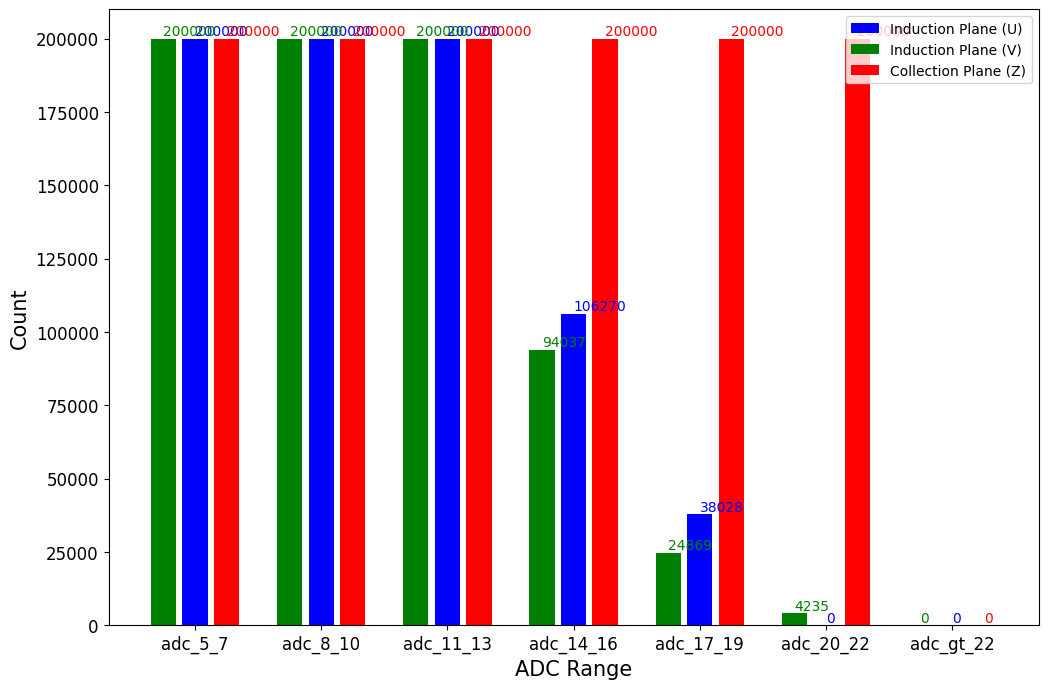

In [10]:
fig = plt.figure(figsize=(12,8))
#plt.title('Number of signal waves grouped by ADC ranges ' + grouping[grp], size=15)

x_labels = [pp.group_num_labels[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], plane_U[1], width=bar_width, color='blue', label='Induction Plane (U)')
plt.bar([i-bar_width - bar_width/4 for i in range(7)], plane_V[1], width=bar_width, color='green', label='Induction Plane (V)')
plt.bar([i+bar_width + bar_width/4 for i in range(7)], plane_Z[1], width=bar_width, color='red', label='Collection Plane (Z)')

for i in range(7):
    dist = 1000
    plt.text(i, plane_U[1][i] + dist, plane_U[1][i], color='blue', size=10)
    plt.text(i-bar_width - bar_width/4, plane_V[1][i] + dist, plane_V[1][i], color='green', size=10)
    plt.text(i+bar_width + bar_width/4, plane_Z[1][i] + dist, plane_Z[1][i], color='red', size=10)


plt.xticks([i for i in range(7)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
#filename = './histograms/file_group' + str(grp) +'.png'
#plt.savefig(filename, facecolor='w', bbox_inches='tight')
plt.show()
plt.close()